# Stochastic Gradient Descent

#### 🎯 Learning Goals

1. Understand the concept of **stochastic gradient descent** to solve an optimization problem.
2. Implement the **stochastic gradient descent** algorithm.

In [1]:
# Load our libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor

# Use a nicer style for plots
plt.style.use("seaborn-v0_8-muted")

___
## Dataset
As with the previous notebook, we will work with the dataset of **bike rentals**. Recall that we keep the following columns:

+ `cnt`: the total number of bike rentals (our target variable).
+ `temp`: the temperature outside (in Celsius, normalized on a scale between 0 and 1).
+ `hum`: the humidity level (normalized on a scale between 0 and 1).
+ `windspeed`: the wind speed (normalized on a scale between 0 and 1).

In [2]:
# Load the bike rental data
rentals = pd.read_csv("data/bike_rental.csv")

# Keep only some columns of interest
rentals = rentals[["cnt", "temp", "hum", "windspeed"]]
rentals.describe()

,cnt,temp,hum,windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000
mean,189.463088,0.496987,0.627229,0.190098
std,181.387599,0.192556,0.192930,0.122340
min,1.000000,0.020000,0.000000,0.000000
25%,40.000000,0.340000,0.480000,0.104500
50%,142.000000,0.500000,0.630000,0.194000
75%,281.000000,0.660000,0.780000,0.253700
max,977.000000,1.000000,1.000000,0.850700


____________
## Stochastic Gradient Descent

The stochastic gradient descent can be thought of as a stochastic approximation of the gradient descent. Similar to the gradient descent the stochastic gradient descent requires the input of a gradient. This time the gradient is not evaluated on the full sample but for a random subset; hence we will refer to this gradient henceforth as stochastic gradient. In high-dimensional settings, evaluating the gradient for a subset of data can be a huge benefit in terms of computational costs.

### Setting 

**Notation** Recall our notation that $\mathbf{x}^{(i)} = [1, x_{1}^{(i)}, x_{2}^{(i)}, \cdots, x_{j}^{(i)}]^T$


Recall the linear model with squared loss function, i.e.

$$
\begin{align*}
\ell(y^{(i)}, f_{\boldsymbol{\beta}}(\mathbf{x}^{(i)})) &= \left(y^{(i)} - \mathbf{x}^{(i)^\mathsf{T}} \boldsymbol{\beta}\right)^2 \\
&= \left(y^{(i)} - \sum_{j=0}^k \beta_j x_j^{(i)} \right)^2.
\end{align*}
$$

#### ➡️ ✏️ Task 1 

Recall that the empirical risk, $\hat{L}(f_{\boldsymbol{\beta}})$, is the average of $\ell(y^{(i)}, f_{\boldsymbol{\beta}}(\mathbf{x}^{(i)}))$. Show that the gradient of the empirical risk is equal to the average of the gradients of $\ell(y^{(i)}, f_{\boldsymbol{\beta}}(\mathbf{x}^{(i)}))$.

In [4]:
def gradient(X, y, beta):
    return -2 * ((y - X.dot(beta)).reshape(-1, 1) * X).mean(axis=0)

n = rentals.shape[0]
X = rentals[["temp", "windspeed", "hum"]].values
X = np.hstack((np.ones((n, 1)), X))
y = rentals["cnt"].values
beta = np.random.randn(4)

total_gradient_l = 0

for i in range(n):
    total_gradient_l += gradient(X[i, :], y[i], beta)

total_gradient_l /= n

total_gradient_L =  gradient(X, y, beta)

print(f"""The gradient via summing the individual losses is {total_gradient_l}
and the gradient computed directly over the whole sample is {total_gradient_L}
""")

The gradient via summing the individual losses is [-377.63652947 -215.83719728  -75.95573386 -214.20064728]
and the gradient computed directly over the whole sample is [-377.63652947 -215.83719728  -75.95573386 -214.20064728]



In [5]:
np.linalg.norm(total_gradient_l - total_gradient_L)

1.1798433219034801e-12

#### ➡️ ✏️ Task 2

The gradient of the linear model with respect to the parameters, $\beta_0, \cdots, \beta_k$ obtains as:

$$\begin{align*}
\nabla_{\boldsymbol{\beta}} \hat{L}(f_{\boldsymbol{\beta}}) &= \begin{bmatrix}\frac{\partial \hat{L}}{\partial \beta_0} \\ \frac{\partial \hat{L}}{\partial \beta_1} \\ \vdots \\ \frac{\partial \hat{L}}{\partial \beta_k}\end{bmatrix} = \begin{bmatrix}
\frac{1}{n}\sum_{i=1}^n\frac{\partial}{\partial \beta_0} \left(y^{(i)} - \sum_{j=0}^k x_j^{(i)}\beta_j \right)^2 \\
\frac{1}{n}\sum_{i=1}^n\frac{\partial}{\partial \beta_1} \left(y^{(i)} - \sum_{j=0}^k x_j^{(i)}\beta_j \right)^2 \\
\vdots \\
\frac{1}{n}\sum_{i=1}^n\frac{\partial}{\partial \beta_k} \left(y^{(i)} - \sum_{j=0}^k x_j^{(i)}\beta_j \right)^2 
\end{bmatrix} \\
&= \begin{bmatrix}
\frac{1}{n}\sum_{i=1}^n - 2 \left  (y^{(i)} - \sum_{j=0}^k x_j^{(i)}\beta_j  \right) \times 1 \\
\frac{1}{n}\sum_{i=1}^n - 2 \left(y^{(i)} - \sum_{j=0}^k x_j^{(i)}\beta_j \right) \times x_1^{(i)} \\
\vdots \\
\frac{1}{n}\sum_{i=1}^n -2\left(y^{(i)} - \sum_{j=0}^k x_j^{(i)}\beta_j \right) \times x_k^{(i)} \\
\end{bmatrix}
\end{align*}$$

+ Write down the stochastic gradient evaluated for a stochastic minibatch $i \in \{s_1, \cdots, s_b\}$.
+ Can you think about a trivial case when stochastic and gradient descent coincide?


## Stochastic Gradient Descent Algorithm

The mechanics of the stochastic gradient descent are the same as for the gradient descent. We update the parameters $\beta$ iteratively by subtracting a scaled version of the stochastic gradient from the current parameters. The scaling factor is called the **learning rate**, $\eta$.

The algorithm reads as follows:

Initialize 
+ the parameters $\boldsymbol{\beta}^{(0)}$ to some random values
+ initialize iteration $t = 0$.

Begin with stochastic gradient descent
1. Sample a random subset of the data, i.e. observations $i \in S$, where $S = \{s_1, \cdots, s_b\}$.
2. Compute the stochastic gradient of the empirical risk with respect to the parameters, $ \frac{1}{b} \sum_{i \in S } \nabla_{\boldsymbol{\beta}}\hat{\ell} (y^{(i)}, f_{\boldsymbol{\beta}^{(t-1)}}(\mathbf{x}^{(i)})) $.
3. Update the parameters by subtracting the learning rate times the stochastic gradient from the current parameters: $$\boldsymbol{\beta}^{(t)} = \boldsymbol{\beta}^{(t-1)} - \eta  \frac{1}{b} \sum_{i \in S} \nabla_{\boldsymbol{\beta}}\hat{\ell} (y^{(i)}, f_{\boldsymbol{\beta}^{(t-1)}}(\mathbf{x}^{(i)})).$$
4. Update $t - 1 = t$
5. Repeat steps 1, 2, and 3,4 until the stopping criterion is met.

_________
#### 🤔 Pause and ponder

+ Why is it computationally cheaper to evaluate the gradient only for a minibatch of the data?
+ Why is it okay to evaluate the gradient on a subset of the data?

_______
#### ➡️ ✏️ Task 2
Adjust the code below to turn the gradient descent to a stochastic gradient descent for a linear regression model of the form:
$$
f_{\boldsymbol{\beta}}(\mathbf{x}) = \beta_0 + \beta_1 \text{temp} + \beta_2 \text{windspeed} + \beta_3 \text{humidity}.
$$

Assume that at each iteration of the algorithm draw randomly $1$ observation from the data to compute the stochastic gradient, i.e. the minibatch size is equal to 1.

In [11]:
betas_list = []    # Initialize a list to keep track of the evolution of the betas over time
eta = 0.5          # The learning rate
beta = np.zeros(4) # Initialize the beta vector to 0

# Add the initial beta to the list
betas_list.append(beta.flatten().copy()) 

t = 0 # Keep track of the number of iterations
max_t = 10000 # Maximum number of iterations

# Set random seed for replicability
np.random.seed(123)

# Adjust the code to make it a stochastic gradient descent algorithm
while t < max_t: # We stop after max_t iterations even if we don't converge
    t += 1

    # Adjust here for stochastic gradient descent
    grad = gradient(X, y, beta)
    
    # Update the beta vector
    beta = beta - eta * grad

    # Add the new beta to the list
    betas_list.append(beta.flatten().copy())

In [12]:
# TODO: REMOVE SOLUTION
n = rentals.shape[0]
X = rentals[["temp", "windspeed", "hum"]].to_numpy()
X = np.hstack((np.ones((n, 1)), X))
y = rentals["cnt"].to_numpy()

betas_list = []    # Initialize a list to keep track of the evolution of the betas over time
eta = 0.3            # The learning rate
beta = np.zeros(4) # Initialize the beta vector to 0

# Add the initial beta to the list
betas_list.append(beta.flatten().copy()) 


t = 0 # Keep track of the number of iterations
max_t = 10000 # Maximum number of iterations
batch_size = 1 # Cardinality of batch size

# Set random seed for replicability
np.random.seed(123)

# Run the stochastic gradient descent algorithm
while t < max_t: # We stop after max_t iterations even if we don't converge
    t += 1
    # Randomly draw a batch of size 100 to compute the gradient
    s = np.random.choice(n, size=batch_size, replace=False)

    # Compute the gradient
    grad = gradient(X[s, :], y[s], beta)
    
    # Update the beta vector
    beta = beta - eta * grad

    # Add the new beta to the list
    betas_list.append(beta.flatten().copy())

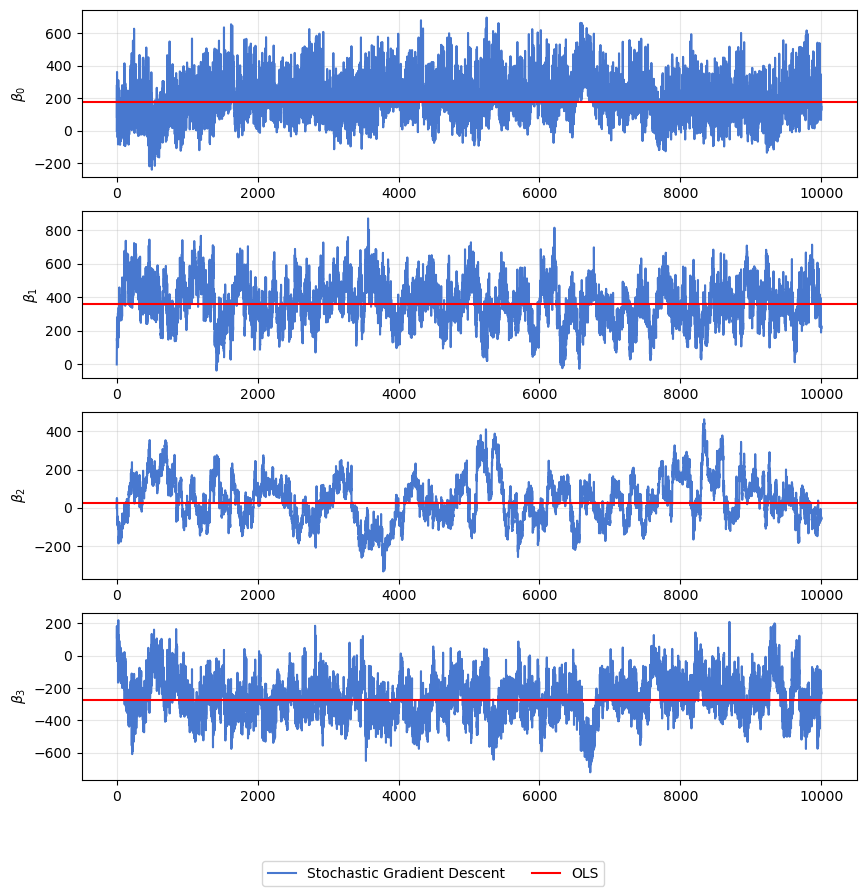

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

beta_ols = np.linalg.inv(X.T @ X) @ X.T @ y # Compute the OLS solution

for i, ax in enumerate(axs):
    ax.plot([beta[i] for beta in betas_list], label=("Stochastic Gradient Descent" if i == 0 else ""))
    ax.axhline(beta_ols[i], color="red", label=("OLS" if i == 0 else ""))
    ax.set_ylabel(r"$\beta_{}$".format(i))
    ax.grid(alpha=0.3)

# Creating a single legend for the figure
fig.legend(loc='lower center', ncol=2)

#### ➡️ ✏️ Task 4 Loss

Rerun the code but now track the loss at each iteration and plot the loss of SGD and OLS. Think about what you see. What do you conclude?

In [14]:
def loss(X, y, beta):
    # Compute MSE
    # TODO Your code
    pass

In [15]:
# TODO: REMOVE SOLUTION
def loss(X, y, beta):
    return ((X@beta - y)**2).mean()

In [16]:
# TODO Compute loss OLS
loss_ols = loss(X, y, beta_ols)

In [17]:
rentals.describe()

,cnt,temp,hum,windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000
mean,189.463088,0.496987,0.627229,0.190098
std,181.387599,0.192556,0.192930,0.122340
min,1.000000,0.020000,0.000000,0.000000
25%,40.000000,0.340000,0.480000,0.104500
50%,142.000000,0.500000,0.630000,0.194000
75%,281.000000,0.660000,0.780000,0.253700
max,977.000000,1.000000,1.000000,0.850700


In [18]:
betas_list = []    # Initialize a list to keep track of the evolution of the betas over time
loss_list = []     # Initialize a list to keep track of the evolution of the loss over time
eta = 0.5          # The learning rate
beta = np.zeros(4) # Initialize the beta vector to 0

# Add the initial beta to the list
betas_list.append(beta.flatten().copy()) 

t = 0 # Keep track of the number of iterations
max_t = 10000 # Maximum number of iterations

# Set random seed for replicability
np.random.seed(123)

# Adjust the code to make it a stochastic gradient descent algorithm
while t < max_t: # We stop after max_t iterations even if we don't converge
    t += 1

    # TODO Copy here your solution
    grad = gradient(X, y, beta)
    
    # Update the beta vector
    beta = beta - eta * grad

    # Add the new beta to the list
    betas_list.append(beta.flatten().copy())

    # Track the loss
    # TODO Your code

In [19]:
# TODO: REMOVE SOLUTION
n = rentals.shape[0]
X = rentals[["temp", "windspeed", "hum"]].values
X = np.hstack((np.ones((n, 1)), X))
y = rentals["cnt"].values

betas_list = []    # Initialize a list to keep track of the evolution of the betas over time
loss_list = []     # Initialize a list to keep track of the evolution of the loss over time
eta = 0.3            # The learning rate
beta = np.zeros(4) # Initialize the beta vector to 0

# Add the initial beta to the list
betas_list.append(beta.flatten().copy()) 


t = 0 # Keep track of the number of iterations
max_t = 500 # Maximum number of iterations
batch_size = 100 # Cardinality of batch size

# Set random seed for replicability
np.random.seed(123)

# Run the stochastic gradient descent algorithm
while t < max_t: # We stop after max_t iterations even if we don't converge
    t += 1
    # Randomly draw a batch of size 100 to compute the gradient
    s = np.random.choice(n, size=batch_size, replace=False)

    # Compute the gradient
    grad = gradient(X[s, :], y[s], beta)
    
    # Update the beta vector
    beta = beta - eta * grad

    # Append the list with the losses
    loss_list.append(loss(X, y, beta))

    # Add the new beta to the list
    betas_list.append(beta.flatten().copy())

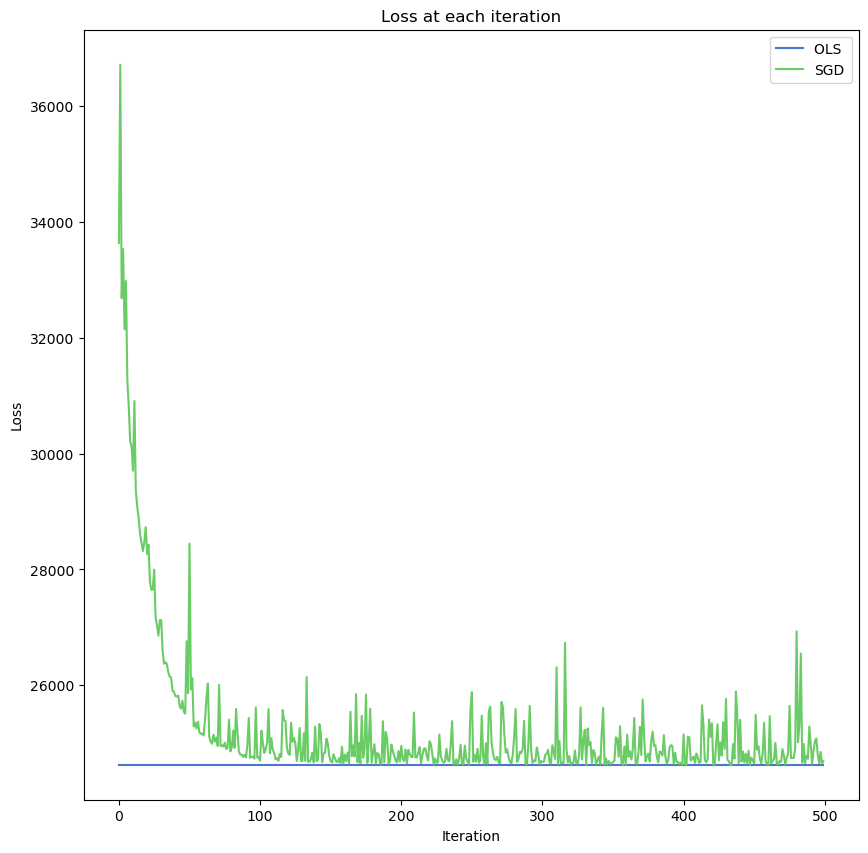

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([loss_ols]*len(loss_list), label="OLS ")
ax.plot(loss_list, label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
plt.legend()
plt.title("Loss at each iteration")
plt.show()

_________
#### 🤔 Pause and ponder

+ What do you observe? 
+ Would you have expected such a loss behaviour?

________
#### ➡️ ✏️ Task 4

Repeat the previous analysis but now set the minibatch size equal to 100. 

+ What do you observe?
+ Increase `max_t`. Why is it harder to accomplish stable coefficient estimates with stochastic gradient descent in contrast to gradient descent?

____
#### &#x1F52D; Stochastic Gradient Descent - Big Picture

- While stochastic gradient descent is fast (cheap) in terms of evaluation, it is slow (expensive) in terms of convergence. For a while, it was for this reason that people gave up on stochastic gradient descent. However, there are adaptations of the stochastic gradient descent to accomodate faster convergence rates. 
- Further, in many machine learning problems the goal is not to optimize to high accuracy. You can use early stopping rules. It also quite common to experiment with step sizes on smaller subsets of the data and then go to the full data. For further details and an on-point discussion refer to [this lecture](https://www.stat.cmu.edu/~ryantibs/convexopt-F18/lectures/stochastic-gd.pdf).
- For details on early stopping criteria not covered in this notebook and e.g. as implemented in `scikit-learn` consult this [website](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_early_stopping.html).

## 🙀 🤯 Non-Convex Optimization Problem

We now explore a non-convex optimization problem where the objective is to minimize a challenging loss function. Suppose we have a single choice variable $x$, and the loss function is defined as:

$$f(x) = -(\operatorname{sin}(x) + x^2 * \operatorname{exp}(-x)) $$

This function exhibits non-convex behavior with multiple local minima. We will see that the Stochastic Gradient Descent (SGD) is effective in this scenario, as its inherent randomness helps it avoid getting stuck in local minima, allowing it to explore the function more and potentially find better solutions.

![Description of the GIF](animations/sgd_gif.gif)